# Digital Signal and Image Management
###### Audio Recognition

> **Cognome**: Filosa    **Nome**: Alberto                                  \\
> **Matricola**: 815589                                                     \\
> **Anno Accademico**: 2020/2021                                            \\
> **Facoltà**: Dipartimento di Informatica, Sistemi e Comunicazione (DISCO) \\
> **Corso di Laurea Magistrale**: Data Science                              \\
> **e-mail**: a.filosa1@campus.unimib.it                                    \\

> **Cognome**: Sofia    **Nome**: Davoli                                  \\
> **Matricola**: 813479                                                     \\
> **Anno Accademico**: 2020/2021                                           \\
> **Facoltà**: Dipartimento di Informatica, Sistemi e Comunicazione (DISCO) \\
> **Corso di Laurea Magistrale**: Data Science                              \\
> **e-mail**: s.davoli1@campus.unimib.it                                    \\

### Indice

* Libreries;
* Reading File;
* Reading Audio;
* Augmentation;
  + Add Noise;
  + Change Speed;
  + Pitch Shifting;
* Final DataFrame;
* Extracting Feature;
* Models:
  + SVM;
  + Logistic;
  + Neural Network;
  + Convolutional Neural Network;
* Recording.


## Libreries

In [8]:
import numpy as np                  #-- Array
import pandas as pd                 #-- DataFrame
from shutil import copyfile         #-- Copy Files
import zipfile                      #-- Extract Zip Files
import random                       #-- Random Numbers
from scipy.io import wavfile as wav #-- Reading File Audio
import matplotlib.pyplot as plt     #-- Graphical Plot
import IPython.display as ipd       #-- File Audio
import pickle                       #-- Save Objects
import seaborn as sns               #-- Plot

#-- Librosa
import librosa
import librosa.display as lid

#-- Sklearn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

#-- Tensorflow
import keras
from keras import models
from keras import layers

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
#@title Reading File {display-mode: "form"}

audio = "/content/gdrive/MyDrive/Università/Data Science/2° Anno/Digital Signal and Image Management/Progetto DSIM/audio_covid.zip"

In [ ]:
copyfile(audio, 'audio_covid.zip')            #-- Copy File Audio

zip = zipfile.ZipFile('audio_covid.zip', 'r') #-- Open File
zip.extractall()                              #-- Extract Files
zip.close()                                   #-- Close Files

First, it is necessary to load the DataFrame containing names of file audio with its respectly class (`covid` and `not_covid`).

In [ ]:
df_audio = pd.read_csv("cough_trial_extended.csv")
df_audio.head()

file_properties      class
0    0v8MGxNetjg_ 10.000_ 20.000.wav  not_covid
1    1j1duoxdxBg_ 70.000_ 80.000.wav  not_covid
2  1MSYO4wgiag_ 120.000_ 130.000.wav  not_covid
3     1PajbAKd8Kg_ 0.000_ 10.000.wav  not_covid
4                           cov1.wav      covid

We had some problems with `37`, `65` and `166` rows cropping audio, so we deleted it.

In [ ]:
df_audio = df_audio.drop([37, 65, 166],                     #-- Remove Rows
                         axis = 0).reset_index(drop = True) #-- Reset Index

We checked classes of audio for umbalanced data.

In [ ]:
df_audio["class"].value_counts()

not_covid    148
covid         19
Name: class, dtype: int64

## Reading Audio

### Covid Audio

In [ ]:
rate_covid, signal_covid = wav.read("trial_covid/cov1.wav")
print("Covid Cough")
ipd.Audio(signal_covid,      #-- Signal
          rate = rate_covid) #-- Rate

Covid Cough


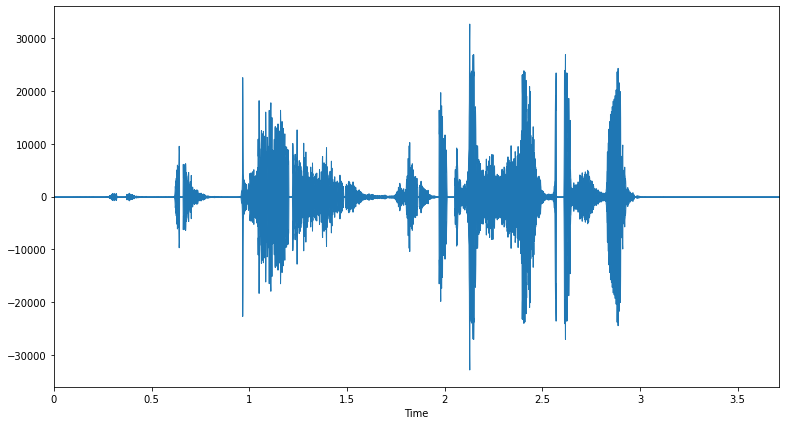

In [ ]:
plt.figure(figsize = (13, 7)) 
librosa.display.waveplot(y = signal_covid.astype(np.float),  #-- Signal
                         sr = rate_covid)                    #-- Rate

Not Covid Audio

In [ ]:
rate_nocovid, signal_nocovid = wav.read("./trial_covid/" + df_audio["file_properties"][11])
print("Non Covid Cough")
ipd.Audio(signal_nocovid,
          rate = rate_nocovid)

Non Covid Cough


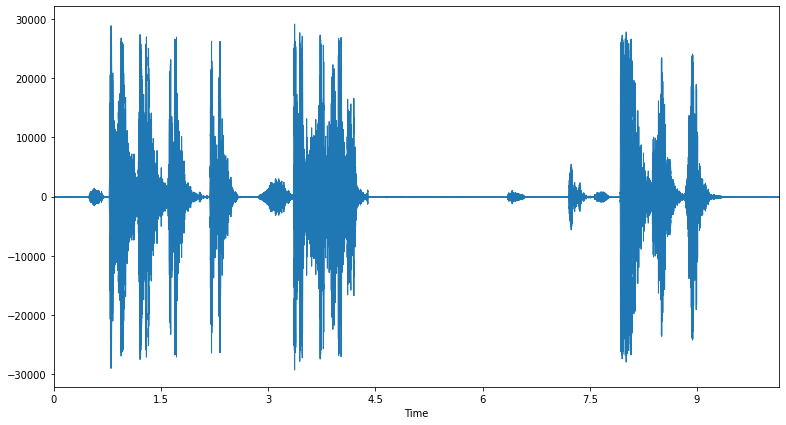

In [ ]:
plt.figure(figsize = (13, 7)) 
librosa.display.waveplot(y = signal_nocovid.astype(np.float),
                         sr = rate_nocovid)

### Read All Audio

We read all audios and we selected one channel audio

In [ ]:
features = [] #-- List of Features Audio
labels = []   #-- List of Labels
rates = []    #-- List of Rates

for el in range(0, len(df_audio)):
  rate, signal = wav.read("./trial_covid/" + df_audio["file_properties"][el]) #-- Read File
  labels.append(df_audio["class"][el])                                        #-- Append Class
  if len(signal.shape) == 2:                    #-- If there are two channels
    features.append(signal[:,0])                #-- Append the Fist One
  else:                                         #-- Otherwise
    features.append(signal)                     #-- Append the Signal
  rates.append(rate)                                                          #-- Append Rate

In [ ]:
list_audio = []

[list_audio.append(len(el)) for el in features] #-- Append Length Signal
df_audio["len_audio"] = list_audio              #-- Add to DataFrame
df_audio["len_audio"].mean()                    #-- Mean Length Audio

249303.15568862276

We calculate for each class the mean length audio. We standardize file audio for have the same signal lenght: audio doesn't change. 

In [ ]:
df_audio.groupby("class").mean()

len_audio
class                   
covid      482034.526316
not_covid  219425.479730

### Standardization

In [ ]:
def audio_stand(data):
  data = (data - np.mean(data))/np.std(data)
  return data

Text(0.5, 1.0, 'Standardized Signal')

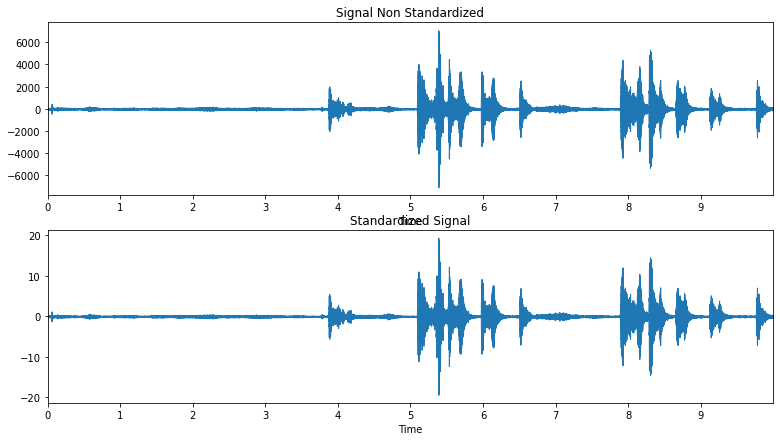

In [ ]:
plt.figure(figsize = (13, 7)) 

plt.subplot(211)
librosa.display.waveplot(y = features[1].astype(np.float),
                         sr = rates[1])
plt.title("Signal Non Standardized")


plt.subplot(212)
librosa.display.waveplot(y = audio_stand(features[1].astype(np.float)),
                         sr = rates[1])
plt.title("Standardized Signal")

In [ ]:
ipd.Audio(features[5],
          rate = rates[5])

In [ ]:
ipd.Audio(audio_stand(features[5]),
          rate = rates[5])

In [ ]:
%%capture
stand_features = []

[stand_features.append(audio_stand(el)) for el in features]

In [ ]:
input_length = 220500

def length_audio_file(signal, input_length):
  if len(signal) >= input_length:

    max_offset = len(signal) - input_length 
    if max_offset == 0:
      offset = 0
    else:
      offset = np.random.randint(max_offset)
    data = signal[offset:(input_length + offset)]

  else:

    max_offset = input_length - len(signal)
    offset = np.random.randint(max_offset)
    data = np.pad(signal,
                  (offset, input_length - len(signal) - offset), 
                  "constant")

  return data

In [ ]:
%%capture
stand_len_feat = [] #-- List of Standardized Arrays

[stand_len_feat.append(length_audio_file(el, #-- Single Standardized Signal
                                         input_length)) for el in stand_features]

In [ ]:
print(len(stand_len_feat[0]))
print(len(stand_features[0]))

220500
220500


In [ ]:
%%capture
list_covid = []

[list_covid.append(stand_len_feat[el]) for el in range(0, len(labels)) if labels[el] == "covid"]

## Augmentation

### Add Noise

It simply add some random value into data by using numpy.

In [ ]:
def add_noise(data, noise_factor):
    noise = np.random.randn(len(data))                    #-- Select Random Value
    augmented_data = data + noise_factor * noise          #-- Add Noise
    augmented_data = augmented_data.astype(type(data[0])) #-- Set Same Data Type
    return augmented_data

In [ ]:
list_noise_covid = []

for el in list_covid:
  noise = random.uniform(0.5, 1.5)     #-- Select Random Values
  noise_audio = add_noise(el, noise)   #-- Add Noise Function
  list_noise_covid.append(noise_audio) #-- Append to List Noise

Text(0.5, 1.0, 'Signal With Noise')

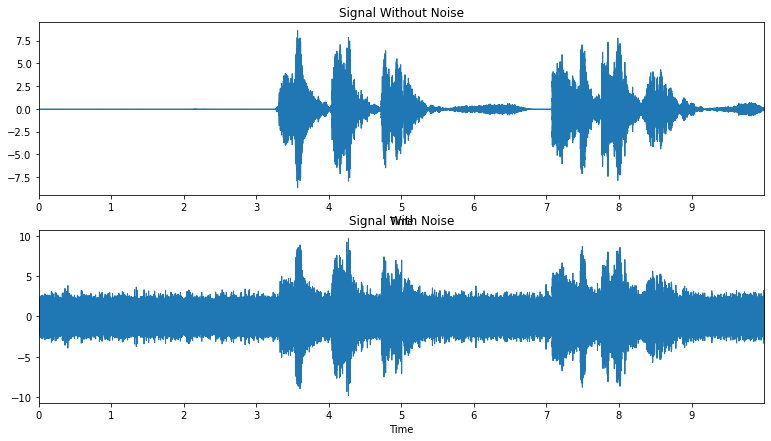

In [ ]:
plt.figure(figsize = (13, 7)) 

plt.subplot(211)
librosa.display.waveplot(y = list_covid[1].astype(np.float),
                         sr = rates[1])
plt.title("Signal Without Noise")

plt.subplot(212)
librosa.display.waveplot(y = list_noise_covid[1].astype(np.float),
                         sr = rates[1])
plt.title("Signal With Noise")

### Change Speed

In [ ]:
def change_speed(data, speed_factor):
    return librosa.effects.time_stretch(data, speed_factor)

In [ ]:
list_speed_covid = []

for el in list_covid:
  speed = random.uniform(0.9, 2.5)              #-- Select Random Speed
  speed_audio = change_speed(el, speed)         #-- Change Speed Function
  speed_audio = length_audio_file(speed_audio,
                                  input_length)
  list_speed_covid.append(speed_audio)          #-- Append to Speed List

Text(0.5, 1.0, 'Signal With Speed')

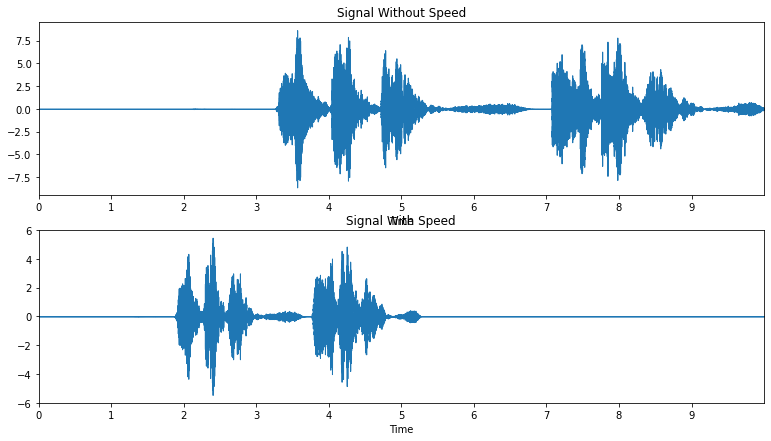

In [ ]:
plt.figure(figsize = (13, 7))

plt.subplot(211)
librosa.display.waveplot(y = list_covid[1].astype(np.float),
                         sr = rates[1])
plt.title("Signal Without Speed")

plt.subplot(212)
librosa.display.waveplot(y = list_speed_covid[1].astype(np.float),
                         sr = rates[1])
plt.title("Signal With Speed")

### Pitch Shifting

In [ ]:
def pitching(data, rate, step):
  return librosa.effects.pitch_shift(data,           #-- Select Audio
                                     rate,           #-- Select Rate
                                     n_steps = step) #-- Number of Steps

In [ ]:
list_pitch_covid = []

for el in list_covid:
  pitch = random.uniform(-5, 5)           #-- Select Random Pitch
  pitch_audio = pitching(el, rate, pitch) #-- Pitch Shifting
  list_pitch_covid.append(pitch_audio)    #-- Append to Pitch List

Text(0.5, 1.0, 'Signal With Pitching')

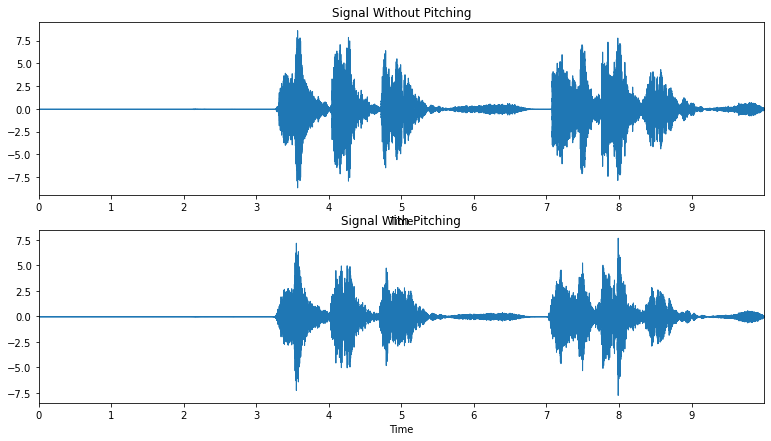

In [ ]:
plt.figure(figsize = (13, 7)) 

plt.subplot(211)
librosa.display.waveplot(y = list_covid[1].astype(np.float),
                         sr = rates[1])
plt.title("Signal Without Pitching")

plt.subplot(212)
librosa.display.waveplot(y = list_pitch_covid[1].astype(np.float),
                         sr = rates[1])
plt.title("Signal With Pitching")

## Final Dataset

Add all augmented audio. There are two balanced lists:

* Balanced Features;
* Balanced Labels.

In [ ]:
balanced_features = stand_len_feat + list_noise_covid + list_speed_covid + list_pitch_covid

In [ ]:
label_covid = []

[label_covid.append("covid") for el in range(0, 57)]

balanced_labels = labels + label_covid
print(len(balanced_labels))

224


In [ ]:
list_names = []

[list_names.append(el) for el in df_audio["file_properties"]] #-- Append Audio File Name
print(len(list_names))

167


Append to Audio File Name new names for augmented audios:

* Covid Noise;
* Covid Speed;
* Covid Pitch.

In [ ]:
%%capture

[list_names.append("covid_noise_" + str(el) + ".wav") for el in range(0, len(list_noise_covid))] #-- Noise

[list_names.append("covid_speed_" + str(el) + ".wav") for el in range(0, len(list_speed_covid))] #-- Speed
  
[list_names.append("covid_pitch_" + str(el) + ".wav") for el in range(0, len(list_pitch_covid))] #-- Pitch

## Add to a DataFrame

In [ ]:
df_audio_balanced = pd.DataFrame(list_names)
df_audio_balanced.columns = ["file_properties"]
df_audio_balanced["label"] = balanced_labels
df_audio_balanced["features"] = balanced_features
df_audio_balanced.head()

file_properties  ...                                           features
0    0v8MGxNetjg_ 10.000_ 20.000.wav  ...  [-0.008806416535092676, -0.010338048778937214,...
1    1j1duoxdxBg_ 70.000_ 80.000.wav  ...  [-0.187904259060693, -0.13042103570175131, -0....
2  1MSYO4wgiag_ 120.000_ 130.000.wav  ...  [0.5384034172570751, 0.23862502153098733, 1.06...
3     1PajbAKd8Kg_ 0.000_ 10.000.wav  ...  [0.00041546565758046106, 0.0004154656575804610...
4                           cov1.wav  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

[5 rows x 3 columns]

Add Features:

* Chroma STFT 1;
* Chroma STFT 6;
* Chroma STFT 12;
* Spectral Centroid;
* Spectral Bandwidth;
* Rolloff;
* Zero Crossing Rate;
* MFCC from 1 to 20.

First, it is necessary to insert the column with float values. Secondly, we modified these values with actual values for each audio.

In [ ]:
df_audio_balanced.insert(3, "chroma_stft_1", 0.1)
df_audio_balanced.insert(4, "chroma_stft_6", 0.1)
df_audio_balanced.insert(5, "chroma_stft_12", 0.1)
df_audio_balanced.insert(6, "spectral_centroid", 0.1)
df_audio_balanced.insert(7, "spectral_bandwidth", 0.1)
df_audio_balanced.insert(8, "rolloff", 0.1)
df_audio_balanced.insert(9, "zcr", 0.1)

for el in range(0, 20):
  df_audio_balanced.insert(el + 10, "mfcc_" + str(el), 0.1)

In [ ]:
%%capture
%%time

for el in range(0, len(df_audio_balanced)):
  df_audio_balanced["chroma_stft_1"][el] = np.mean(librosa.feature.chroma_stft(y = df_audio_balanced["features"][el],
                                                                               sr = rate)[0])
  df_audio_balanced["chroma_stft_6"][el] = np.mean(librosa.feature.chroma_stft(y = df_audio_balanced["features"][el],
                                                                               sr = rate)[5])
  df_audio_balanced["chroma_stft_12"][el] = np.mean(librosa.feature.chroma_stft(y = df_audio_balanced["features"][el],
                                                                                sr = rate)[11])
  df_audio_balanced["spectral_centroid"][el] = np.mean(librosa.feature.spectral_centroid(y = df_audio_balanced["features"][el],
                                                                                         sr = rate))
  df_audio_balanced["spectral_bandwidth"][el] = np.mean(librosa.feature.spectral_bandwidth(y = df_audio_balanced["features"][el],
                                                                                         sr = rate))
  df_audio_balanced["rolloff"][el] = np.mean(librosa.feature.spectral_rolloff(y = df_audio_balanced["features"][el],
                                                                              sr = rate))
  df_audio_balanced["zcr"][el] = np.mean(librosa.feature.zero_crossing_rate(y = df_audio_balanced["features"][el]))

  for i in range(0, 20):
    df_audio_balanced["mfcc_" + str(i)][el] = np.mean(librosa.feature.mfcc(y = df_audio_balanced["features"][el],
                                                                           sr = rate)[i])

In [ ]:
df_audio_balanced

file_properties      label  ...   mfcc_18   mfcc_19
0      0v8MGxNetjg_ 10.000_ 20.000.wav  not_covid  ... -2.674302 -4.100836
1      1j1duoxdxBg_ 70.000_ 80.000.wav  not_covid  ...  1.533411  2.148497
2    1MSYO4wgiag_ 120.000_ 130.000.wav  not_covid  ... -2.089377 -3.747838
3       1PajbAKd8Kg_ 0.000_ 10.000.wav  not_covid  ... -4.964725 -1.994196
4                             cov1.wav      covid  ... -2.719657 -2.056986
..                                 ...        ...  ...       ...       ...
219                 covid_pitch_14.wav      covid  ... -0.596268  0.058618
220                 covid_pitch_15.wav      covid  ... -2.412686  1.483407
221                 covid_pitch_16.wav      covid  ... -4.851828 -9.178660
222                 covid_pitch_17.wav      covid  ... -5.486272 -2.007967
223                 covid_pitch_18.wav      covid  ... -4.329488 -1.763968

[224 rows x 30 columns]

In [ ]:
#@title Saving Files {display-mode: "form"}

with open('df_audio_final.pkl', 'wb') as f:
  pickle.dump(df_audio_balanced, f)

!cp df_audio_final.pkl '/content/gdrive/MyDrive/Università/Data Science/2° Anno/Digital Signal and Image Management/Progetto DSIM/df_audio_final.pkl'

In [ ]:
#@title Loading Files {display-mode: "form"}

infile = open('/content/gdrive/MyDrive/Università/Data Science/2° Anno/Digital Signal and Image Management/Progetto DSIM/df_audio_final_2.pkl','rb')
df_audio_balanced = pickle.load(infile)

# Model

* Support Vector Machine (SVM);
* Neaural Network (NN);
* Convolutional Neural Network (CNN).

In [ ]:
df_audio_balanced[df_audio_balanced.columns[3:]].head() #-- Select these Features

chroma_stft_1  chroma_stft_6  chroma_stft_12  ...   mfcc_17   mfcc_18   mfcc_19
0       0.626644       0.420032        0.515128  ... -1.232411 -3.024776 -2.049019
1       0.816778       0.211407        0.761408  ... -3.147559 -2.052967 -1.890074
2       0.477495       0.601515        0.502879  ... -3.694798 -6.969705 -1.762924
3       0.637575       0.374858        0.402032  ...  0.023597 -6.891567 -0.880096
4       0.306443       0.380538        0.353021  ... -1.999831 -0.402588 -1.511467

[5 rows x 27 columns]

In [ ]:
df_audio_balanced.iloc[:, 1][:5]

0    not_covid
1    not_covid
2    not_covid
3    not_covid
4        covid
Name: label, dtype: object

In [ ]:
label = df_audio_balanced.iloc[:, 1] #-- Select Label
encoder = LabelEncoder()
y = encoder.fit_transform(label)     #-- Binarization of Labels
y                                    #-- 1 no covid, 0 covid

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_audio_balanced[df_audio_balanced.columns[3:]],
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 123456)

## SVM

In [ ]:
param_grid = {'C': [10, 50, 1e3],                        #-- Insert
              'gamma': [0.00001, 0.005, 0.1, 0.5, 1.0]} #-- Insert

#-- Support Vector Machine Initialization
clf = GridSearchCV(SVC(kernel = 'rbf',             #-- Kernel
                       class_weight = "balanced"), #-- Class Weight
                    param_grid,                    #-- Select Best Parameter
                    cv = 5)                        #-- Cross Validation

#-- Training
clf = clf.fit(X_train, y_train)

In [ ]:
#-- Result of the Cross Validation for Parameters Selection
print('Best parameters combination:')
print(' C: '+ str(clf.best_estimator_.C))
print(' gamma: '+ str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 10
 gamma: 1e-05


Classification report:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85        25
           1       0.89      0.95      0.92        43

    accuracy                           0.90        68
   macro avg       0.90      0.88      0.89        68
weighted avg       0.90      0.90      0.90        68

Confusion matrix:


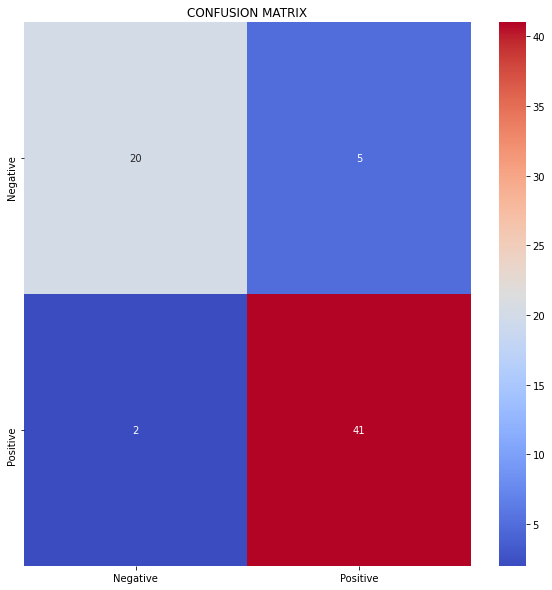

In [ ]:
y_pred = clf.predict(X_test)

#-- Classificaiton Report
print('Classification report:')
print(classification_report(y_test, y_pred))

#-- Confusion Matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)

#-- Plot the Confusion Matrix
plt.figure(figsize = (10, 10))
plt.title('CONFUSION MATRIX')
sns.heatmap(cm, cmap = 'coolwarm',
            yticklabels = ['Negative', 'Positive'],  #-- Y Labels
            xticklabels = ['Negative', 'Positive'],  #-- X Labels
            annot = True);

## Logistic Regression

In [ ]:
log = LogisticRegression(solver = 'liblinear',
                         random_state = 123456,
                         class_weight = "balanced")

log.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123456, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

In [ ]:
score = log.score(X_test, y_test)
print(score)

0.9558823529411765


In [ ]:
importance = log.coef_[0]

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v)) #-- MFCC most important

Feature: 0, Score: 0.00056
Feature: 1, Score: -0.01149
Feature: 2, Score: -0.00596
Feature: 3, Score: -0.00439
Feature: 4, Score: 0.00350
Feature: 5, Score: 0.00093
Feature: 6, Score: -0.00315
Feature: 7, Score: 0.02325
Feature: 8, Score: 0.05110
Feature: 9, Score: -0.03079
Feature: 10, Score: 0.22426
Feature: 11, Score: -0.57758
Feature: 12, Score: 0.04431
Feature: 13, Score: -0.32325
Feature: 14, Score: 0.36815
Feature: 15, Score: 0.01977
Feature: 16, Score: 0.40355
Feature: 17, Score: -0.13825
Feature: 18, Score: 0.48419
Feature: 19, Score: -0.20507
Feature: 20, Score: 0.45921
Feature: 21, Score: -0.14942
Feature: 22, Score: -0.08063
Feature: 23, Score: 0.03720
Feature: 24, Score: 0.24742
Feature: 25, Score: -0.13244
Feature: 26, Score: 0.19739


In [ ]:
y_pred = log.predict(X_test)

print('Classification report:')
print(classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        25
           1       0.98      0.95      0.96        43

    accuracy                           0.96        68
   macro avg       0.95      0.96      0.95        68
weighted avg       0.96      0.96      0.96        68



[[24  1]
 [ 2 41]]


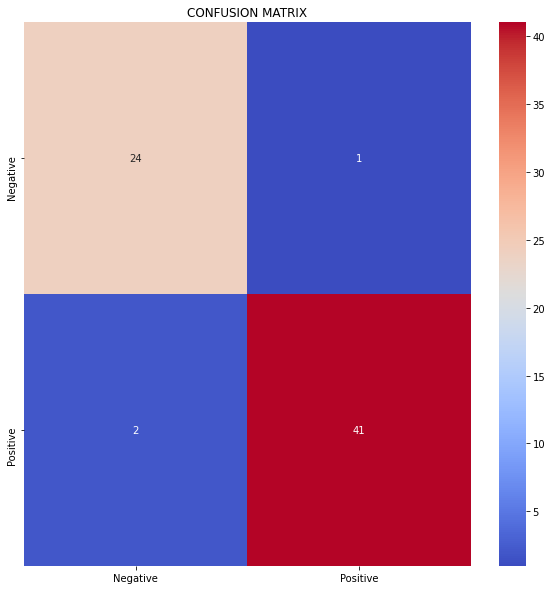

In [ ]:
cm = confusion_matrix(y_test, log.predict(X_test))
print(cm)

#-- Plot the Confusion Matrix
plt.figure(figsize = (10, 10))
plt.title('CONFUSION MATRIX')
sns.heatmap(cm, cmap = 'coolwarm',
            yticklabels = ['Negative', 'Positive'],  #-- Y Labels
            xticklabels = ['Negative', 'Positive'],  #-- X Labels
            annot = True);

## Neural Network

In [ ]:
model = models.Sequential()
model.add(layers.Dense(512, activation = 'relu',
                       input_shape = (X_train.shape[1],)))
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(10, activation = 'relu'))
model.add(layers.Dense(2, activation = 'softmax'))

In [ ]:
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs = 120,
                    batch_size = 20)

Epoch 1/120
8/8 [==============================] - 0s 2ms/step - loss: 194.4946 - accuracy: 0.4942
Epoch 2/120
8/8 [==============================] - 0s 2ms/step - loss: 0.8650 - accuracy: 0.3633
Epoch 3/120
8/8 [==============================] - 0s 2ms/step - loss: 0.6943 - accuracy: 0.2973
Epoch 4/120
8/8 [==============================] - 0s 2ms/step - loss: 0.6936 - accuracy: 0.2836
Epoch 5/120
8/8 [==============================] - 0s 3ms/step - loss: 0.6920 - accuracy: 0.6706
Epoch 6/120
8/8 [==============================] - 0s 3ms/step - loss: 0.6912 - accuracy: 0.6235
Epoch 7/120
8/8 [==============================] - 0s 3ms/step - loss: 0.6899 - accuracy: 0.6322
Epoch 8/120
8/8 [==============================] - 0s 3ms/step - loss: 0.6871 - accuracy: 0.6812
Epoch 9/120
8/8 [==============================] - 0s 3ms/step - loss: 0.6864 - accuracy: 0.6525
Epoch 10/120
8/8 [==============================] - 0s 3ms/step - loss: 0.6855 - accuracy: 0.6391
Epoch 11/120
8/8 [=========

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Accuracy Test: ', test_acc)

3/3 [==============================] - 0s 4ms/step - loss: 0.6596 - accuracy: 0.6324
Accuracy Test:  0.6323529481887817


Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.63      1.00      0.77        43

    accuracy                           0.63        68
   macro avg       0.32      0.50      0.39        68
weighted avg       0.40      0.63      0.49        68

[[ 0 25]
 [ 0 43]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


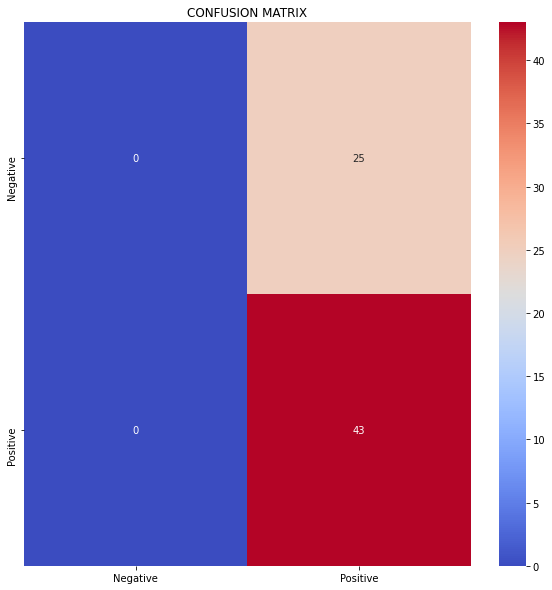

In [ ]:
y_pred = model.predict(X_test, verbose = 0)
y_pred = np.argmax(y_pred, axis = 1)

print('Classification report:')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print(cm)

#-- Plot the Confusion Matrix
plt.figure(figsize = (10, 10))
plt.title('CONFUSION MATRIX')
sns.heatmap(cm, cmap = 'coolwarm',
            yticklabels = ['Negative', 'Positive'],  #-- Y Labels
            xticklabels = ['Negative', 'Positive'],  #-- X Labels
            annot = True);

## Convolutional Neural Network

In [ ]:
X = np.array(df_audio_balanced[df_audio_balanced.columns[3:]]) #-- Transform to an Array
X = np.expand_dims(X, axis = -1)
X.shape

(224, 27, 1)

In [ ]:
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X,
                                                                    y,
                                                                    test_size = 0.3,
                                                                    random_state = 123456)

In [ ]:
num_classes = 2
yc_train = keras.utils.to_categorical(y_train_cnn, num_classes)
yc_test = keras.utils.to_categorical(y_test_cnn, num_classes)

### Model 1

In [ ]:
model_cnn_1 = keras.Sequential()
model_cnn_1.add(keras.Input((27, 1)))
model_cnn_1.add(keras.layers.Conv1D(64, 3, activation='relu'))
model_cnn_1.add(keras.layers.Conv1D(64, 3, activation='relu'))
model_cnn_1.add(keras.layers.MaxPooling1D(3))
model_cnn_1.add(keras.layers.Dropout(0.2))
model_cnn_1.add(keras.layers.Conv1D(128, 3, activation='relu'))
model_cnn_1.add(keras.layers.Conv1D(128, 3, activation='relu'))
model_cnn_1.add(keras.layers.GlobalAveragePooling1D())
model_cnn_1.add(keras.layers.Dense(2, activation='softmax'))

In [ ]:
model_cnn_1.compile(loss = keras.losses.categorical_crossentropy,
                  optimizer = keras.optimizers.Adadelta(),
                  metrics = ['accuracy'])

history_cnn1 = model_cnn_1.fit(X_train_cnn, yc_train,
                               batch_size = 12,
                               epochs = 80,
                               verbose = 1,
                               validation_data = (X_test_cnn, yc_test));

Epoch 1/80
13/13 [==============================] - 1s 19ms/step - loss: 47.2494 - accuracy: 0.6771 - val_loss: 45.7882 - val_accuracy: 0.6324
Epoch 2/80
13/13 [==============================] - 0s 6ms/step - loss: 42.2163 - accuracy: 0.6992 - val_loss: 44.7141 - val_accuracy: 0.6324
Epoch 3/80
13/13 [==============================] - 0s 5ms/step - loss: 39.8320 - accuracy: 0.6460 - val_loss: 43.6200 - val_accuracy: 0.6324
Epoch 4/80
13/13 [==============================] - 0s 6ms/step - loss: 39.6017 - accuracy: 0.7214 - val_loss: 42.6301 - val_accuracy: 0.6324
Epoch 5/80
13/13 [==============================] - 0s 6ms/step - loss: 30.5471 - accuracy: 0.7108 - val_loss: 41.6174 - val_accuracy: 0.6324
Epoch 6/80
13/13 [==============================] - 0s 7ms/step - loss: 39.6372 - accuracy: 0.6834 - val_loss: 40.6241 - val_accuracy: 0.6324
Epoch 7/80
13/13 [==============================] - 0s 6ms/step - loss: 41.3150 - accuracy: 0.6718 - val_loss: 39.5876 - val_accuracy: 0.6324
Epoch

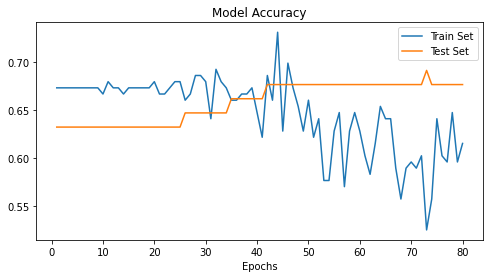

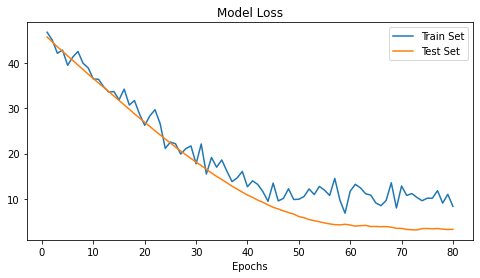

In [ ]:
acc = history_cnn1.history['accuracy']         #-- Train Accuracy
val_acc = history_cnn1.history['val_accuracy'] #-- Validation Accuracy
loss = history_cnn1.history['loss']            #-- Loss Function
val_loss = history_cnn1.history['val_loss']    #-- Validation Loss
epochs_range = range(1, 80 + 1)                #-- Number of Epochs

#-- Model Accuracy Loss
plt.figure(figsize = (8, 4))
plt.plot(epochs_range,
         acc,
         label = 'Train Set')
plt.plot(epochs_range,
         val_acc,
         label = 'Test Set')

plt.legend(loc = "best")
plt.xlabel('Epochs')
plt.title('Model Accuracy')
plt.show()

#-- Model Loss Plot
plt.figure(figsize = (8,4))
plt.plot(epochs_range,
         loss,
         label = 'Train Set')
plt.plot(epochs_range,
         val_loss,
         label = 'Test Set')
plt.legend(loc = "best")
plt.xlabel('Epochs')
plt.title('Model Loss')
plt.show()

In [ ]:
score = model_cnn_1.evaluate(X_test_cnn, yc_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3/3 [==============================] - 0s 16ms/step - loss: 13.7330 - accuracy: 0.6765
Test loss: 13.733028411865234
Test accuracy: 0.6764705777168274


### Model 2

In [ ]:
model_cnn_2 = keras.Sequential()
model_cnn_2.add(keras.Input((27, 1)))
model_cnn_2.add(keras.layers.Conv1D(filters = 512, kernel_size = 10))
model_cnn_2.add(keras.layers.Conv1D(filters = 256, kernel_size = 10))
model_cnn_2.add(keras.layers.MaxPooling1D())
model_cnn_2.add(keras.layers.Dense(10))
model_cnn_2.add(keras.layers.Flatten())
model_cnn_2.add(keras.layers.Dense(2, activation = 'softmax'))

In [ ]:
model_cnn_2.compile(loss = keras.losses.categorical_crossentropy,
                  optimizer = keras.optimizers.Adadelta(),
                  metrics = ['accuracy'])

history_cnn2 = model_cnn_2.fit(X_train_cnn, yc_train,
                               batch_size = 12,
                               epochs = 80,
                               verbose = 1,
                               validation_data = (X_test_cnn, yc_test));

Epoch 1/80
13/13 [==============================] - 8s 47ms/step - loss: 18.3974 - accuracy: 0.7025 - val_loss: 3.3667 - val_accuracy: 0.6029
Epoch 2/80
13/13 [==============================] - 0s 8ms/step - loss: 3.0221 - accuracy: 0.6471 - val_loss: 1.8248 - val_accuracy: 0.6765
Epoch 3/80
13/13 [==============================] - 0s 7ms/step - loss: 1.9258 - accuracy: 0.7228 - val_loss: 1.6909 - val_accuracy: 0.7206
Epoch 4/80
13/13 [==============================] - 0s 8ms/step - loss: 2.2836 - accuracy: 0.7116 - val_loss: 1.4150 - val_accuracy: 0.7647
Epoch 5/80
13/13 [==============================] - 0s 8ms/step - loss: 1.7164 - accuracy: 0.7063 - val_loss: 4.8655 - val_accuracy: 0.5000
Epoch 6/80
13/13 [==============================] - 0s 7ms/step - loss: 2.8320 - accuracy: 0.7024 - val_loss: 1.2226 - val_accuracy: 0.7941
Epoch 7/80
13/13 [==============================] - 0s 7ms/step - loss: 1.4585 - accuracy: 0.7696 - val_loss: 1.4559 - val_accuracy: 0.7500
Epoch 8/80
13/13 [

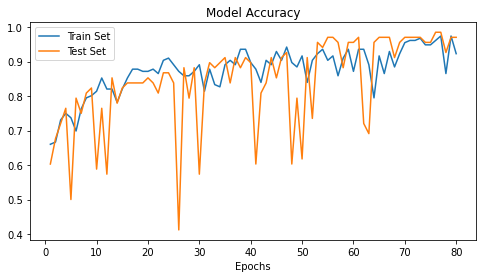

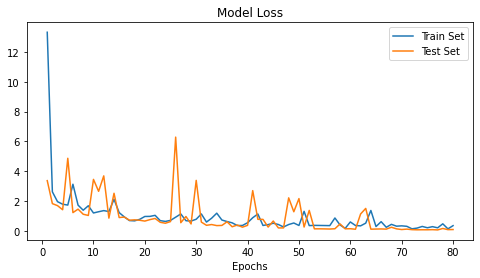

In [ ]:
acc = history_cnn2.history['accuracy']         #-- Train Accuracy
val_acc = history_cnn2.history['val_accuracy'] #-- Validation Accuracy
loss = history_cnn2.history['loss']            #-- Loss Function
val_loss = history_cnn2.history['val_loss']    #-- Validation Loss
epochs_range = range(1, 80 + 1)                #-- Number of Epochs

#-- Model Accuracy Loss
plt.figure(figsize = (8, 4))
plt.plot(epochs_range,
         acc,
         label = 'Train Set')
plt.plot(epochs_range,
         val_acc,
         label = 'Test Set')

plt.legend(loc = "best")
plt.xlabel('Epochs')
plt.title('Model Accuracy')
plt.show()

#-- Model Loss Plot
plt.figure(figsize = (8,4))
plt.plot(epochs_range,
         loss,
         label = 'Train Set')
plt.plot(epochs_range,
         val_loss,
         label = 'Test Set')
plt.legend(loc = "best")
plt.xlabel('Epochs')
plt.title('Model Loss')
plt.show()

In [ ]:
score = model_cnn_2.evaluate(X_test_cnn, yc_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3/3 [==============================] - 0s 18ms/step - loss: 0.0882 - accuracy: 0.9706
Test loss: 0.08818169683218002
Test accuracy: 0.970588207244873


## Predict Best Model (CNN)

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        25
           1       0.98      0.98      0.98        43

    accuracy                           0.97        68
   macro avg       0.97      0.97      0.97        68
weighted avg       0.97      0.97      0.97        68

[[24  1]
 [ 1 42]]


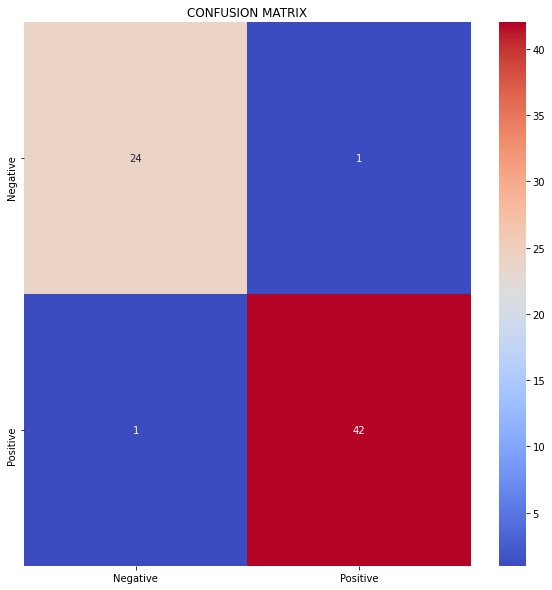

In [ ]:
y_pred_cnn = model_cnn_2.predict(X_test_cnn)
y_pred_cnn = np.argmax(y_pred_cnn, axis = 1)
#print(y_pred_cnn)

print('Classification report:')
print(classification_report(y_test_cnn, y_pred_cnn))

cm = confusion_matrix(y_test_cnn, y_pred_cnn)
print(cm)

#-- Plot the Confusion Matrix
plt.figure(figsize = (10, 10))
plt.title('CONFUSION MATRIX')
sns.heatmap(cm, cmap = 'coolwarm',
            yticklabels = ['Negative', 'Positive'],  #-- Y Labels
            xticklabels = ['Negative', 'Positive'],  #-- X Labels
            annot = True);

# Recording and Test Cough

In [ ]:
%%capture

!sudo apt-get install libportaudio2
!pip install sounddevice == 0.2.1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 17 not upgraded.
Need to get 64.6 kB of archives.
After this operation, 215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Fetched 64.6 kB in 1s (114 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 146425 files

In [ ]:
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec = 3):
  print("Recording ...")
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  with open('audio.wav','wb') as f:
    f.write(b)
  return 'audio.wav'

In [9]:
record()

Recording ...


<IPython.core.display.Javascript object>

'audio.wav'

In [10]:
signal, rate = librosa.load("audio.wav")
ipd.Audio(signal, rate = rate)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


First, it is necessary to load manualli the model `cnn_audio.h5`.

In [ ]:
def kwow_if_you_are_posivite(audio):
  signal, rate = librosa.load(audio)

  #-- Create DataFrame
  new_audio = pd.DataFrame()
  new_audio["filename"] = 0
  new_audio.loc[0] = audio

  #-- Add Features
  new_audio["chroma_stft_1"] = np.mean(librosa.feature.chroma_stft(y = signal, sr = rate)[0])
  new_audio["chroma_stft_6"] = np.mean(librosa.feature.chroma_stft(y = signal, sr = rate)[5])
  new_audio["chroma_stft_12"] = np.mean(librosa.feature.chroma_stft(y = signal, sr = rate)[11])
  new_audio["spectral_centroid"] = np.mean(librosa.feature.spectral_centroid(y = signal, sr = rate))
  new_audio["spectral_bandwidth"] = np.mean(librosa.feature.spectral_bandwidth(y = signal,  sr = rate))
  new_audio["rolloff"] = np.mean(librosa.feature.spectral_rolloff(y = signal, sr = rate))
  new_audio["zcr"] = np.mean(librosa.feature.zero_crossing_rate(y = signal))

  for i in range(0, 20):
    new_audio["mfcc_" + str(i)] = np.mean(librosa.feature.mfcc(y = signal, sr = rate)[i])  
  
  new_audio = np.array(new_audio[new_audio.columns[1:]]) #-- Transform to an Array
  new_audio = np.expand_dims(new_audio, axis = -1)

  model = keras.models.load_model("cnn_audio.h5")
  y_pred = model.predict(new_audio, verbose = 0)
  y_pred = np.argmax(y_pred, axis = 1)

  if y_pred == 1:
    print("Oh Man! You Are Positive to COVID-19! Stay Safe!")
  else:
    print("Lucky You! You are Negative to COVID-19. Wear your mask and Stay Safe!")

  return y_pred

In [11]:
kwow_if_you_are_posivite("audio.wav")

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Lucky You! You are Negative to COVID-19. Wear your mask and Stay Safe!


array([0])